In [314]:
# Import all necessary libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
from selenium import webdriver
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel
import re
import string
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import numpy as np
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas_datareader import data
import mplfinance as mpf
from math import pi
import statsmodels.api as sm

In [286]:
# Web scrapping financial news urls from thestreet.com 
def get_news(stock):
    
    req = Request(url='https://finviz.com/quote.ashx?t='+stock, headers={'user-agent': 'my-app/0.0.1'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    stock_tr = news_table.findAll('tr')
    for i, table_row in enumerate(stock_tr):
        # Read the text of the element 'a' into 'link_text'
        a_text = table_row.a.text
        # Read the text of the element 'td' into 'data_text'
        td_text = table_row.td.text
    parsed_news = [['Stock', 'Date', 'Time', 'Headline']]

    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]

        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([stock, date, time, text])
    df = pd.DataFrame(parsed_news[1:], columns=parsed_news[0])
    df.Date = pd.to_datetime(df.Date)
    df.Time = pd.to_datetime(df.Time, format='%I:%M%p').dt.time
    
    return df

In [287]:
def clean_news(text):
    
    stopwords_set = set(stopwords.words('english'))
    #Remove punctuations and stopwords
    cleaned = " ".join([i for i in re.sub(r'[^\w\s]', " ", text).lower().split() if i not in stopwords_set])
    # Remove single characters from the start
    cleaned = re.sub(r'\^[a-zA-Z]\s+', ' ', cleaned) 
    # Remove single characters
    cleaned = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned)
    # Remove words with containing numbers
    cleaned = re.sub('\w*\d\w*', '', cleaned)
    
    return cleaned

In [361]:
def ssa_generator(stock):
    
    # Web-scrapping stock news from Finviz.com website into Pandas Dataframe
    df = get_news(stock)
    # Generate cleaned news headline dataframe
    news_clean = pd.DataFrame(df.Headline.apply(clean_news))
    # Rename news column to cleaned news
    news_clean['Cleaned_News'] = news_clean.Headline
    # add the cleaned news column into the original dataframe
    df = df.join(news_clean['Cleaned_News'], rsuffix='_right')     
    # Instantiate the vader sentiment intensity analyzer
    vader = SentimentIntensityAnalyzer()
    # Iterate through the headlines and get the polarity scores using vader
    stock_scores = df['Cleaned_News'].apply(vader.polarity_scores).tolist()
    # Convert the 'scores' list of dicts into a DataFrame
    stock_scores_df = pd.DataFrame(stock_scores)
    # Join the DataFrames of the news and the list of dicts
    final_df = df.join(stock_scores_df, rsuffix='_right')
    
    return final_df

In [362]:
# Generate news dataframe for stock NIO
nio = ssa_generator('NIO')
nio

,Stock,Date,Time,Headline,Cleaned_News,neg,neu,pos,compound
0,NIO,2021-01-12,15:03:00,Dow Jones Rallies As Bulls Battle Bears; GM St...,dow jones rallies bulls battle bears gm stock ...,0.178,0.822,0.000,-0.3818
1,NIO,2021-01-12,11:58:00,"If you don't own Amazon stock, 'you're actuall...",amazon stock actually short veteran trader,0.000,0.746,0.254,0.1779
2,NIO,2021-01-12,11:52:00,Why Tesla Stock Jumped on Tuesday,tesla stock jumped tuesday,0.000,1.000,0.000,0.0000
3,NIO,2021-01-12,11:48:00,Dow Jones Falls As Tesla Snaps Back; Nio Rever...,dow jones falls tesla snaps back nio reverses ...,0.172,0.828,0.000,-0.3612
4,NIO,2021-01-12,09:38:00,"Target, Expedia, NIO, Tesla and NVIDIA highlig...",target expedia nio tesla nvidia highlighted za...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
95,NIO,2020-12-31,11:36:00,Tesla Stock To Close 2020 With Epic Gain As Ni...,tesla stock close epic gain nio eyes even big...,0.000,0.726,0.274,0.5267
96,NIO,2020-12-31,10:12:00,Nio To Match Vehicle Prices Through Jan. 10 As...,nio match vehicle prices jan china plans ev ...,0.189,0.811,0.000,-0.2732
97,NIO,2020-12-31,08:17:00,Dow Jones Futures: Stock Market Rally Caps 202...,dow jones futures stock market rally caps tes...,0.000,0.773,0.227,0.4767
98,NIO,2020-12-31,08:00:00,Alibaba Boosts Top China Play Near Buy Point; ...,alibaba boosts top china play near buy point n...,0.000,0.552,0.448,0.6705


In [301]:
# Generate news dataframe for stock XPEV
xpeng = ssa_generator('XPEV')
xpeng

,Stock,Date,Time,Headline,Cleaned_News,Polarity,Subjectivity,neg,neu,pos,compound
0,XPEV,2021-01-11,11:55:00,China Auto Sales Fall For Third Straight Year ...,china auto sales fall third straight year viru...,0.100000,0.200000,0.000,0.840,0.160,0.2263
1,XPEV,2021-01-11,09:32:00,Nio Races Higher After Unveiling Luxury Electr...,nio races higher unveiling luxury electric car...,0.100000,0.450000,0.000,1.000,0.000,0.0000
2,XPEV,2021-01-11,08:26:00,Dow Jones Futures: Extended Stock Market Rally...,dow jones futures extended stock market rally ...,0.136364,0.454545,0.000,1.000,0.000,0.0000
3,XPEV,2021-01-11,06:27:00,Nio's stock jumps into record territory after ...,nio stock jumps record territory unveiling lu...,0.000000,0.000000,0.000,1.000,0.000,0.0000
4,XPEV,2021-01-09,11:43:00,Dow Jones Futures: Extended Stock Market Rally...,dow jones futures extended stock market rally ...,0.136364,0.454545,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
95,XPEV,2020-12-03,16:07:00,Here's The New Highest Tesla Price Target And ...,new highest tesla price target shares could jump,0.136364,0.454545,0.000,0.761,0.239,0.2960
96,XPEV,2020-12-03,09:04:00,"XPeng downgraded at UBS, as stock has run up t...",xpeng downgraded ubs stock run much keep buying,0.200000,0.200000,0.000,1.000,0.000,0.0000
97,XPEV,2020-12-03,05:00:00,Stop Dissing Electric-Car Companies Already,stop dissing electric car companies already,0.000000,0.000000,0.306,0.694,0.000,-0.2960
98,XPEV,2020-12-02,16:05:00,"Li Auto, Nio, Xpeng EV Sales Jump As Wall Stre...",li auto nio xpeng ev sales jump wall street se...,0.000000,0.000000,0.000,1.000,0.000,0.0000


In [302]:
# Generate news dataframe for stock LI
li = ssa_generator('LI')
li

,Stock,Date,Time,Headline,Cleaned_News,Polarity,Subjectivity,neg,neu,pos,compound
0,LI,2021-01-11,11:55:00,China Auto Sales Fall For Third Straight Year ...,china auto sales fall third straight year viru...,0.100000,0.200000,0.000,0.840,0.160,0.2263
1,LI,2021-01-11,09:32:00,Nio Races Higher After Unveiling Luxury Electr...,nio races higher unveiling luxury electric car...,0.100000,0.450000,0.000,1.000,0.000,0.0000
2,LI,2021-01-11,08:26:00,Dow Jones Futures: Extended Stock Market Rally...,dow jones futures extended stock market rally ...,0.136364,0.454545,0.000,1.000,0.000,0.0000
3,LI,2021-01-11,06:27:00,Nio's stock jumps into record territory after ...,nio stock jumps record territory unveiling lu...,0.000000,0.000000,0.000,1.000,0.000,0.0000
4,LI,2021-01-09,13:47:00,Benzinga's First Bulls And Bears Of 2021: Ford...,benzinga first bulls bears ford mastercard pe...,0.250000,0.333333,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
95,LI,2020-11-25,14:21:00,The Top Reasons Li Auto Could Accelerate to Hi...,top reasons li auto could accelerate higher highs,0.375000,0.500000,0.000,0.795,0.205,0.2023
96,LI,2020-11-25,13:25:00,Nio Investors Are Facing the Bubble,nio investors facing bubble,0.000000,0.000000,0.000,1.000,0.000,0.0000
97,LI,2020-11-24,16:03:00,"Tesla, Nikola Rally While Chinese Electric Car...",tesla nikola rally chinese electric car stocks...,0.000000,0.000000,0.000,1.000,0.000,0.0000
98,LI,2020-11-23,17:03:00,Dow Jones Futures: Latest Bitcoin Play In Buy ...,dow jones futures latest bitcoin play buy zone...,0.650000,0.900000,0.000,0.733,0.267,0.6249


In [292]:
def daily_ssa_generator(stock):
    
    # Web-scrapping stock news from Finviz.com website into Pandas Dataframe
    df = get_news(stock)
    # Generate group by date Dataframe
    gbd_df = df.groupby(df.Date).size().reset_index(name='count')
    # Change Date column from Datetime Object to String
    gbd_df.Date = gbd_df.Date.astype(str)
    # Import Yahoo Finance data using DateReader
    daily_df = data.DataReader(stock, 
                       start='2020-12-20', 
                       end='2021-1-11', 
                       data_source='yahoo')
    # Keep necessary columns for further analysis
    daily_df = daily_df[['Open','High','Low','Adj Close','Volume']].reset_index()
    # Create price change column
    daily_df['Price Change'] = daily_df['Adj Close'].pct_change().fillna(0)
    # Create volume change column
    daily_df['Volume Change'] = daily_df['Volume'].pct_change().fillna(0)
    # Change Date column from Datetime Object into String to match gbd_df
    daily_df.Date = daily_df.Date.astype(str)
    # Merge daily_df with gbd_df on Date column
    daily_df = daily_df.merge(gbd_df, how='left',on='Date').fillna(0)
    # Calculate mean scores for all columns
    daily_mean_scores = ssa_generator(stock).groupby(['Date']).mean().unstack()
    # Generate daily Textbolb Sentiment Score
    daily_blob_mean_score = daily_mean_scores.xs('Polarity').transpose()
    daily_blob_mean_score = pd.DataFrame({'Date':daily_blob_mean_score.index, 'blob score':daily_blob_mean_score.values})
    daily_blob_mean_score.Date = daily_blob_mean_score.Date.astype(str)
    # Generate daily Vader Sentiment Score
    daily_vader_mean_score = daily_mean_scores.xs('compound').transpose()
    daily_vader_mean_score = pd.DataFrame({'Date':daily_vader_mean_score.index, 'vader score':daily_vader_mean_score.values})
    daily_vader_mean_score.Date = daily_vader_mean_score.Date.astype(str)
    # Add daily Textbolb Score column
    daily_df = daily_df.merge(daily_blob_mean_score, how='left',on='Date').fillna(0)
    # Add daily Vader Score column
    daily_df = daily_df.merge(daily_vader_mean_score, how='left',on='Date').fillna(0)
    
    return daily_df

In [284]:
# Import NIO financial data from Yahoo Finance using DataReader into Pandas DataFrame
yahoo_nio = data.DataReader("NIO", 
                            start='2020-12-20', 
                            end='2021-1-11', 
                            data_source='yahoo')
yahoo_nio

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-21,49.490002,45.020000,45.630001,48.950001,132558100,48.950001
2020-12-22,49.840000,46.529999,49.610001,47.580002,117118300,47.580002
2020-12-23,48.360001,45.810001,47.480000,47.009998,81247900,47.009998
2020-12-24,47.130001,45.349998,46.880001,45.770000,60582500,45.770000
2020-12-28,46.849998,43.669998,46.669998,44.060001,105078000,44.060001
2020-12-29,46.279999,42.230000,43.700001,46.139999,120689900,46.139999
2020-12-30,48.380001,45.720001,46.500000,48.380001,116691700,48.380001
2020-12-31,50.500000,47.770000,48.459999,48.740002,129124600,48.740002
2021-01-04,54.450001,50.669998,51.200001,53.490002,213109700,53.490002


In [303]:
# Import XPEV financial data from Yahoo Finance using DataReader into Pandas DataFrame
yahoo_xpeng = data.DataReader("XPEV", 
                            start='2020-12-20', 
                            end='2021-1-11', 
                            data_source='yahoo')
yahoo_xpeng

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-21,47.880001,45.020000,45.110001,46.970001,18790900,46.970001
2020-12-22,47.490002,43.750000,47.419998,45.049999,19407600,45.049999
2020-12-23,44.959999,43.080002,44.770000,43.799999,13495200,43.799999
2020-12-24,44.200001,41.639999,43.040001,41.869999,15453300,41.869999
2020-12-28,41.860001,37.500000,41.790001,38.009998,30945500,38.009998
2020-12-29,41.818001,37.599998,38.750000,41.549999,24437000,41.549999
2020-12-30,43.240002,41.164001,42.830002,42.290001,20341500,42.290001
2020-12-31,44.660000,41.950001,42.779999,42.830002,21903100,42.830002
2021-01-04,47.689999,43.480000,45.599998,44.099998,39630300,44.099998


In [304]:
# Import LI financial data from Yahoo Finance using DataReader into Pandas DataFrame
yahoo_li = data.DataReader("LI", 
                            start='2020-12-20', 
                            end='2021-1-11', 
                            data_source='yahoo')
yahoo_li

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-21,33.700001,31.110001,31.164000,32.860001,20322600,32.860001
2020-12-22,33.580002,30.629999,33.480000,31.290001,16996200,31.290001
2020-12-23,31.430000,29.400000,31.290001,30.559999,14670100,30.559999
2020-12-24,30.379999,29.139999,30.290001,29.320000,13413700,29.320000
2020-12-28,29.789000,26.879999,29.746000,27.010000,22950600,27.010000
2020-12-29,29.000000,26.520000,27.309999,28.670000,18394000,28.670000
2020-12-30,29.440001,28.521000,29.270000,29.059999,17018300,29.059999
2020-12-31,30.150000,28.760000,29.360001,28.830000,15507100,28.830000
2021-01-04,33.000000,29.610001,30.340000,32.459999,46632700,32.459999


In [293]:
# Generate daily NIO news dataframe with both Textbolb and Vader Sentiment Score
daily_nio = daily_ssa_generator('NIO')
daily_nio

,Date,Open,High,Low,Adj Close,Volume,Price Change,Volume Change,count,blob score,vader score
0,2020-12-21,45.630001,49.490002,45.020000,48.950001,132558100,0.000000,0.000000,0.0,0.000000,0.000000
1,2020-12-22,49.610001,49.840000,46.529999,47.580002,117118300,-0.027988,-0.116476,0.0,0.000000,0.000000
2,2020-12-23,47.480000,48.360001,45.810001,47.009998,81247900,-0.011980,-0.306275,0.0,0.000000,0.000000
3,2020-12-24,46.880001,47.130001,45.349998,45.770000,60582500,-0.026377,-0.254350,0.0,0.000000,0.000000
4,2020-12-28,46.669998,46.849998,43.669998,44.060001,105078000,-0.037361,0.734461,2.0,0.125000,0.170000
5,2020-12-29,43.700001,46.279999,42.230000,46.139999,120689900,0.047208,0.148574,6.0,0.035000,0.025467
6,2020-12-30,46.500000,48.380001,45.720001,48.380001,116691700,0.048548,-0.033128,7.0,0.130996,-0.007357
7,2020-12-31,48.459999,50.500000,47.770000,48.740002,129124600,0.007441,0.106545,10.0,0.171174,0.275780
8,2021-01-04,51.200001,54.450001,50.669998,53.490002,213109700,0.097456,0.650419,16.0,0.072893,0.049919
9,2021-01-05,51.970001,53.750000,50.400002,53.200001,147474800,-0.005422,-0.307986,7.0,0.038961,-0.025214


In [305]:
# Generate daily XPEV news dataframe with both Textbolb and Vader Sentiment Score
daily_xpeng = daily_ssa_generator('XPEV')
daily_xpeng

,Date,Open,High,Low,Adj Close,Volume,Price Change,Volume Change,count,blob score,vader score
0,2020-12-21,45.110001,47.880001,45.020000,46.970001,18790900,0.000000,0.000000,5,0.140952,0.119600
1,2020-12-22,47.419998,47.490002,43.750000,45.049999,19407600,-0.040877,0.032819,1,0.136364,0.250000
2,2020-12-23,44.770000,44.959999,43.080002,43.799999,13495200,-0.027747,-0.304644,3,0.066667,-0.254367
3,2020-12-24,43.040001,44.200001,41.639999,41.869999,15453300,-0.044064,0.145096,1,0.000000,0.000000
4,2020-12-28,41.790001,41.860001,37.500000,38.009998,30945500,-0.092190,1.002517,1,0.250000,0.000000
5,2020-12-29,38.750000,41.818001,37.599998,41.549999,24437000,0.093133,-0.210321,3,0.083333,-0.075433
6,2020-12-30,42.830002,43.240002,41.164001,42.290001,20341500,0.017810,-0.167594,2,0.000000,0.000000
7,2020-12-31,42.779999,44.660000,41.950001,42.830002,21903100,0.012769,0.076769,6,0.219949,0.231650
8,2021-01-04,45.599998,47.689999,43.480000,44.099998,39630300,0.029652,0.809347,12,0.107096,0.107025
9,2021-01-05,44.130001,44.990002,41.619999,42.340000,22844800,-0.039909,-0.423552,4,0.100000,0.159550


In [306]:
# Generate daily LI news dataframe with both Textbolb and Vader Sentiment Score
daily_li = daily_ssa_generator('LI')
daily_li

,Date,Open,High,Low,Adj Close,Volume,Price Change,Volume Change,count,blob score,vader score
0,2020-12-21,31.164000,33.700001,31.110001,32.860001,20322600,0.000000,0.000000,3.0,0.183333,0.067433
1,2020-12-22,33.480000,33.580002,30.629999,31.290001,16996200,-0.047778,-0.163680,0.0,0.000000,0.000000
2,2020-12-23,31.290001,31.430000,29.400000,30.559999,14670100,-0.023330,-0.136860,2.0,0.100000,-0.381550
3,2020-12-24,30.290001,30.379999,29.139999,29.320000,13413700,-0.040576,-0.085644,0.0,0.000000,0.000000
4,2020-12-28,29.746000,29.789000,26.879999,27.010000,22950600,-0.078786,0.710982,2.0,0.125000,-0.229400
5,2020-12-29,27.309999,29.000000,26.520000,28.670000,18394000,0.061459,-0.198539,3.0,0.000000,0.030633
6,2020-12-30,29.270000,29.440001,28.521000,29.059999,17018300,0.013603,-0.074791,2.0,0.000000,0.000000
7,2020-12-31,29.360001,30.150000,28.760000,28.830000,15507100,-0.007915,-0.088799,3.0,0.061111,0.391500
8,2021-01-04,30.340000,33.000000,29.610001,32.459999,46632700,0.125910,2.007184,13.0,0.097576,0.126023
9,2021-01-05,32.400002,33.189999,30.450001,30.990000,24022000,-0.045286,-0.484868,3.0,0.000000,-0.058833


In [397]:
# Create candlestick plot with vader sentiment score of NIO
apd_nio = mpf.make_addplot(daily_nio['vader score'],panel='lower',color='b', ylim=[-0.5,0.5], ylabel='Sentiment Score')
saving_params = dict(fname='nio_mpf.png', dpi=300)
mpf.plot(yahoo_nio, addplot=apd_nio, type='candle',style='yahoo',
            title='NIO, 12/20/20 - 1/11/21',
            ylabel='Price ($)',
            ylabel_lower='Shares \nTraded',
            volume=True,
            savefig=saving_params)


In [398]:
# Create candlestick plot with vader sentiment score of XPEV
apd_xpeng = mpf.make_addplot(daily_xpeng['vader score'],panel='lower',color='b', ylim=[-0.5,0.5], ylabel='Sentiment Score')
saving_params2 = dict(fname='xpeng_mpf.png', dpi=300)
mpf.plot(yahoo_xpeng, addplot=apd_xpeng, type='candle',style='yahoo',
            title='XPEV, 12/20/20 - 1/11/21',
            ylabel='Price ($)',
            ylabel_lower='Shares \nTraded',
            volume=True,
            savefig=saving_params2)

In [399]:
# Create candlestick plot with vader sentiment score of LI
apd_li = mpf.make_addplot(daily_li['vader score'],panel='lower',color='b', ylim=[-0.5,0.5], ylabel='Sentiment Score')
saving_params3 = dict(fname='li_mpf.png', dpi=300)
mpf.plot(yahoo_li, addplot=apd_li, type='candle',style='yahoo',
            title='LI, 12/20/20 - 1/11/21',
            ylabel='Price ($)',
            ylabel_lower='Shares \nTraded',
            volume=True,
            savefig=saving_params3)


NIO:  
 [('nio', 39), ('stock', 37), ('tesla', 29), ('new', 25), ('jones', 16), ('buy', 12), ('record', 11), ('ev', 10), ('apple', 9), ('sedan', 9), ('market', 9), ('rally', 8), ('day', 8), ('high', 7), ('futures', 7), ('hits', 6), ('china', 6), ('higher', 5), ('unveiling', 5), ('car', 5), ('stocks', 5), ('surges', 5), ('falls', 4), ('gains', 4), ('luxury', 4), ('sales', 4), ('year', 4), ('annual', 4), ('price', 4), ('battery', 4), ('jumps', 4), ('point', 4), ('ahead', 4), ('dow', 3), ('amid', 3), ('daynio', 3), ('bitcoin', 3), ('convertible', 3), ('model', 3), ('chinese', 3)]


<ipython-input-369-49ae47a74006>:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



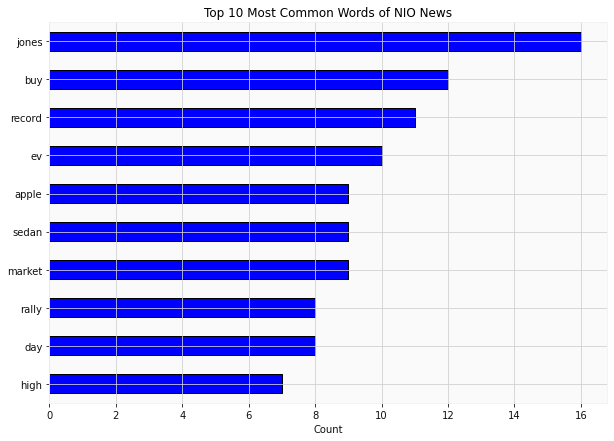

In [369]:
# Create bag of words of NIO
bow_nio = ''.join(nio['Cleaned_News']).split()
# Print out top 40 most common words of NIO
print('NIO'+': ' + f' \n {Counter(bow_nio).most_common(40)}')
add_stop_words = [word for word, count in Counter(bow_nio).most_common() if count > 20]
remove = ['also', 'was', 'more', 'will', 'by', 'or']
for word in remove:
    add_stop_words.append(word)
stop_words = ENGLISH_STOP_WORDS.union(add_stop_words)
wc_words = [word for word in bow_nio if word not in add_stop_words]
wc_words_counts = Counter(wc_words).most_common(50)
counter = pd.DataFrame(wc_words_counts,columns=('word','count'))
plot = counter.iloc[:10].plot.barh(x='word', y='count', color = 'blue', figsize=(10,7), legend=False, edgecolor='k')
_ = plt.xlabel('Count')
_ = plt.title('Top 10 Most Common Words of NIO News')


ax1 = plt.axes()
y_ax = ax1.axes.get_yaxis()
y_ax.label.set_visible(False)

plt.gca().invert_yaxis()
plt.savefig('nio_bow.png', dpi=300)

XPEV:  
 [('stock', 32), ('tesla', 20), ('nio', 19), ('ev', 19), ('xpeng', 15), ('new', 13), ('auto', 11), ('car', 11), ('buy', 11), ('stocks', 11), ('electric', 10), ('jones', 9), ('market', 9), ('china', 8), ('offering', 8), ('sales', 7), ('li', 7), ('futures', 6), ('rally', 6), ('chinese', 6), ('public', 6), ('rise', 5), ('could', 5), ('share', 5), ('higher', 4), ('record', 4), ('musk', 4), ('street', 4), ('lidar', 4), ('apple', 4), ('december', 4), ('top', 4), ('growth', 4), ('vehicle', 4), ('announces', 4), ('prices', 4), ('jump', 4), ('first', 4), ('year', 3), ('run', 3)]


<ipython-input-370-20dab6dba7f3>:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



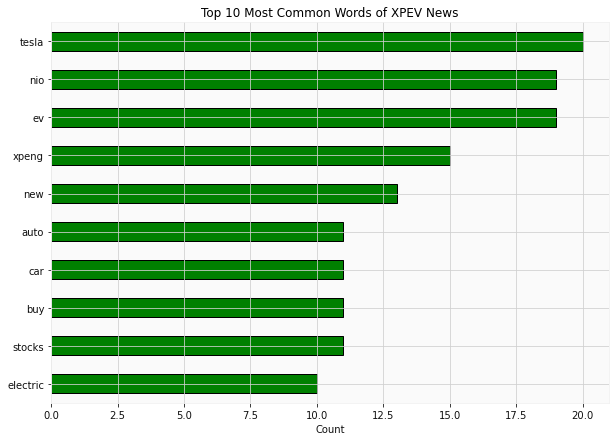

In [370]:
bow_xpeng = ''.join(xpeng['Cleaned_News']).split()
print('XPEV'+': ' + f' \n {Counter(bow_xpeng).most_common(40)}')
add_stop_words = [word for word, count in Counter(bow_xpeng).most_common() if count > 20]
remove = ['also', 'was', 'more', 'will', 'by', 'or']
for word in remove:
    add_stop_words.append(word)
stop_words = ENGLISH_STOP_WORDS.union(add_stop_words)
wc_words = [word for word in bow_xpeng if word not in add_stop_words]
wc_words_counts = Counter(wc_words).most_common(50)
counter = pd.DataFrame(wc_words_counts,columns=('word','count'))
plot = counter.iloc[:10].plot.barh(x='word', y='count', color = 'green', figsize=(10,7), legend=False, edgecolor='k')
_ = plt.xlabel('Count')
_ = plt.title('Top 10 Most Common Words of XPEV News')


ax1 = plt.axes()
y_ax = ax1.axes.get_yaxis()
y_ax.label.set_visible(False)

plt.gca().invert_yaxis()
plt.savefig('xpeng_bow.png', dpi=300)

LI:  
 [('stock', 36), ('auto', 25), ('tesla', 23), ('nio', 21), ('ev', 17), ('buy', 14), ('jones', 13), ('li', 13), ('futures', 11), ('china', 10), ('stocks', 10), ('car', 9), ('market', 9), ('new', 9), ('xpeng', 9), ('offering', 9), ('electric', 8), ('apple', 8), ('sales', 7), ('rally', 7), ('public', 7), ('delivery', 5), ('top', 5), ('chinese', 5), ('inc', 5), ('share', 5), ('higher', 4), ('jumps', 4), ('record', 4), ('first', 4), ('street', 4), ('growth', 4), ('rise', 4), ('prices', 4), ('could', 4), ('jump', 4), ('big', 4), ('musk', 3), ('high', 3), ('price', 3)]


<ipython-input-371-5af153d4fce2>:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



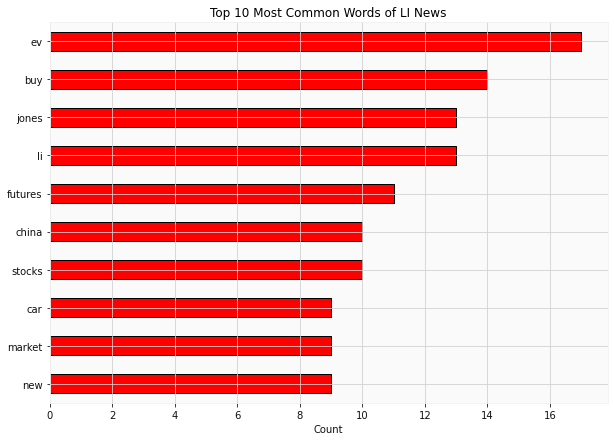

In [371]:
bow_li = ''.join(li['Cleaned_News']).split()
print('LI'+': ' + f' \n {Counter(bow_li).most_common(40)}')
add_stop_words = [word for word, count in Counter(bow_li).most_common() if count > 20]
remove = ['also', 'was', 'more', 'will', 'by', 'or']
for word in remove:
    add_stop_words.append(word)
stop_words = ENGLISH_STOP_WORDS.union(add_stop_words)
wc_words = [word for word in bow_li if word not in add_stop_words]
wc_words_counts = Counter(wc_words).most_common(50)
counter = pd.DataFrame(wc_words_counts,columns=('word','count'))
plot = counter.iloc[:10].plot.barh(x='word', y='count', color = 'red', figsize=(10,7), legend=False, edgecolor='k')
_ = plt.xlabel('Count')
_ = plt.title('Top 10 Most Common Words of LI News')


ax1 = plt.axes()
y_ax = ax1.axes.get_yaxis()
y_ax.label.set_visible(False)

plt.gca().invert_yaxis()
plt.savefig('li_bow.png', dpi=300)

In [349]:
# Conduct OLS Regression between vader sentiment score and next day's stock price change of NIO
X = daily_nio['vader score'][0:-1]
y = daily_nio['Price Change'][1:].reset_index(drop=True)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Users/hangyin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Price Change   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                              9.312
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                      0.0101
Time:                        14:00:44   Log-Likelihood:                          22.709
No. Observations:                  13   AIC:                                     -43.42
Df Residuals:                      12   BIC:                                     -42.85
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
vader score     0.3872      0.127      3.051      0.010       0.111       0.664
==============================================================================
Omnibus:                        2.699   Durbin-Watson:                   0.706
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                1.827
Skew:                           0.884   Prob(JB):                        0.401
Kurtosis:                       2.500   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [345]:
# Conduct OLS Regression between vader sentiment score and next day's stock price change of XPEV
X2 = daily_xpeng['vader score'][0:-1]
y2 = daily_xpeng['Price Change'][1:].reset_index(drop=True)
model2 = sm.OLS(y2, X2).fit()
predictions2 = model2.predict(X2)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Price Change   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.082
Method:                 Least Squares   F-statistic:                            0.01395
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                       0.908
Time:                        13:47:34   Log-Likelihood:                          20.136
No. Observations:                  13   AIC:                                     -38.27
Df Residuals:                      12   BIC:                                     -37.71
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
vader score     0.0117      0.099      0.118      0.908      -0.204       0.228
==============================================================================
Omnibus:                        1.076   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                0.642
Skew:                           0.516   Prob(JB):                        0.725
Kurtosis:                       2.651   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [346]:
# Conduct OLS Regression between vader sentiment score and next day's stock price change of LI
X3 = daily_li['vader score'][0:-1]
y3 = daily_li['Price Change'][1:].reset_index(drop=True)
model3 = sm.OLS(y3, X3).fit()
predictions3 = model3.predict(X3)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Price Change   R-squared (uncentered):                   0.222
Model:                            OLS   Adj. R-squared (uncentered):              0.157
Method:                 Least Squares   F-statistic:                              3.417
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                      0.0893
Time:                        13:48:36   Log-Likelihood:                          19.833
No. Observations:                  13   AIC:                                     -37.67
Df Residuals:                      12   BIC:                                     -37.10
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
vader score     0.1546      0.084      1.848      0.089      -0.028       0.337
==============================================================================
Omnibus:                        0.642   Durbin-Watson:                   2.604
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.621
Skew:                           0.239   Prob(JB):                        0.733
Kurtosis:                       2.042   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

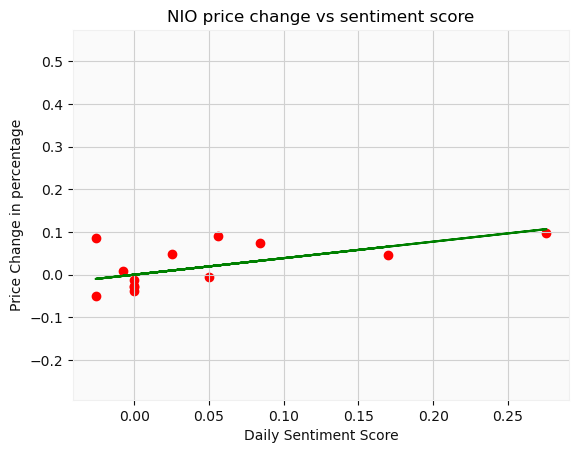

In [392]:
plt.scatter(X, y, color = "red")
plt.plot(X, predictions, color = "green")
plt.title("NIO price change vs sentiment score")
ymin, ymax = plt.ylim()
plt.ylim(ymin * 5, ymax * 5)

plt.xlabel("Daily Sentiment Score")
plt.ylabel("Price Change in percentage")
plt.savefig('nio_cor.png', dpi=300)
plt.show()


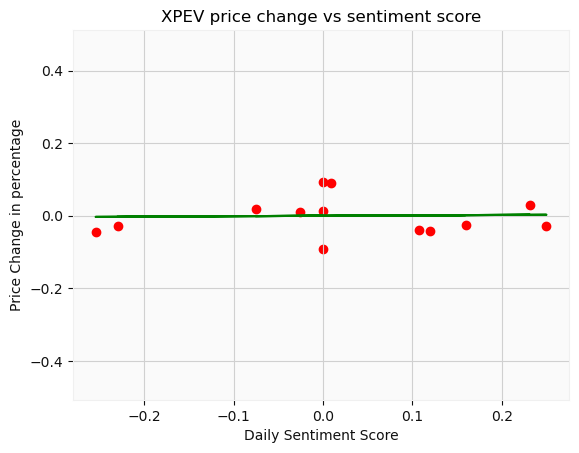

In [393]:
plt.scatter(X2, y2, color = "red")
plt.plot(X2, predictions2, color = "green")
plt.title("XPEV price change vs sentiment score")
ymin, ymax = plt.ylim()
plt.ylim(ymin * 5, ymax * 5)

plt.xlabel("Daily Sentiment Score")
plt.ylabel("Price Change in percentage")
plt.savefig('xpeng_cor.png', dpi=300)
plt.show()


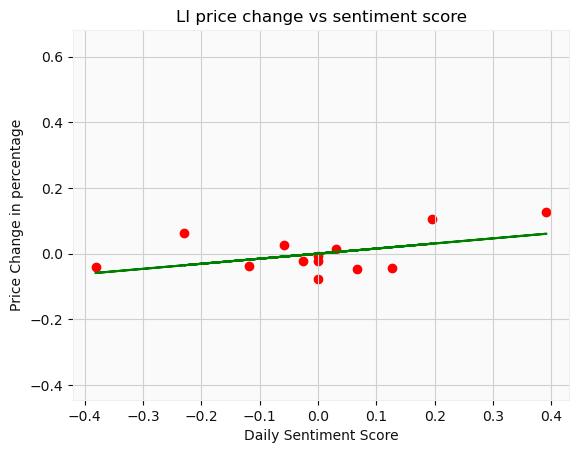

In [394]:
plt.scatter(X3, y3, color = "red")
plt.plot(X3, predictions3, color = "green")
plt.title("LI price change vs sentiment score")
ymin, ymax = plt.ylim()
plt.ylim(ymin * 5, ymax * 5)

plt.xlabel("Daily Sentiment Score")
plt.ylabel("Price Change in percentage")
plt.savefig('li_cor.png', dpi=300)
plt.show()